<img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60">
<center>
    <h1> A brief comparative of models for market stock forecasting: Financial News models v/s Autoregressive models </h1>
    <h2> INF-522 Text Mining </h2>
    <h2> Camilo Núñez Fernández </h2>
    <h2> Martes 21 de Diciembre del 2021 </h2>
</center>

In [1]:
#!pip install -r requirements.txt

In [2]:
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Introducción

El estudio de los activos financiero en el mercado actual es un tarea esencial en la economía de todos los países del mundo, los cuales han de modelar múltiples procesos complejos que involucran grandes cantidades de datos, tanto actuales como históricos de cada nación. Uno de los principales métodos de modelación de activos financieros son las series de tiempo. Gracias a ellas, es posible determinar mecanismos de regulación y sintetización de fenómenos complejos que vive el mercado. Una de estos fenómenos es la predicción de activos. Para la predicción de activos financieros es necesario aplicar metodologías que van desde el análisis de la estacionalidad de la serie de tiempo, hasta selección del modelo que mejor se ajuste al caso.

En la actualidad existen múltiples modelos y técnicas que pueden determinar los factores más importantes al momento de hacer las predicciones de un activo, los cuales por otro lado quedan determinados según los datos que se usen y la cantidad de periodos que se busquen predecir. Para ello, técnicas modernas como las redes neuronales pueden significar una gran ventaja por sobre modelos clásico que solo podrían aproximar datos por medio de regresiones. Por otro lado, la inclusión de datos semánticos, como noticias financieras, pueden generar que estos modelos de redes neuronales más complejos tengas mejores desempeños en predicciones a largo plazo ([li2019dplstm](https://arxiv.org/abs/1912.10806)). Por otro lado, la combinación de modelos clásicos con modelos complejos como redes neuronales recurrentes ([DBLP:journals/corr/abs-1808-01560](https://dblp.org/rec/journals/corr/abs-1808-01560.bib)) también han demostrado ser una opción viable capaz de adecuarse a las condiciones actuales del marcado para predecir activos.

Sin embargo, en la mayoría de los casos, utilizar modelos de alta complejidad como las redes neuronales por sobre modelos más simples y clásicos, como un modelo autorregresivos y/o de medias móviles, no guarda mucho sentido, si lo que se busca es predecir datos a corto o mediano tiempo ([DBLP:journals/corr/abs-1808-01560](https://dblp.org/rec/journals/corr/abs-1808-01560.bib)). Para ello, la selección del modelo correcto que se ajuste mejor a los datos es un factor importante que han de considerar tanto en el rendimiento como en la capacidad de computo que se dispone para ello.

## Problema 🔴
Utilizar modelos de alta complejidad como las redes neuronales por sobre modelos más simples y clásicos, como un modelo autorregresivos y/o de medias móviles, no guarda mucho sentido, si lo que se busca es predecir datos a corto o mediano tiempo.

## Objetivo 🔴
Comparar los modelos _ARMA_, _GARCH_, _Prophet_ y _ARMA-GARCH_, entrenados solo con $\{x_{t}\}$, contra modelos de capas _GRU_ y/o _LSTM_, entrenados con $\{x_{t}\}$ y $\{W_{t}\}$. (Donde $\{W_{t}\}$ es la representación vectorial de un documento)

# Notación y Background

En esta sección se formalizará el uso y la notación de las series de tiempo utilizadas y sus respectivas características y propiedades. A continuación se desarrollará de manera breve la teoría de los modelos utilizados.

🔴 Se considerará una serie de tiempo como una secuencia de variables aleatorias denotadas por el conjunto de variables $\{x_{t}\}$, con $t$ el índice discreto auto incremental descrito como $t=0, \pm 1, \pm 2, \ldots$ y utilizado para denotar la temporalidad ordenada de la variable aleatoria.

## Series de Tiempo Financieras
Defínase una serie de tiempo financiera como aquella que describe la valorización de uno o más activos a lo largo del tiempo.
Para el estudio de estas series en el desarrollo de esta investigación se considerarán las siguientes dos características:
* __Retorno__ 🔴: Sea el retorno $y_{t}$ en el tiempo $t$ el coeficiente entre el valor del activo descrito por la variable $x_{t}$ en el tiempo $t$ y el valor del activo en el tiempo $t-1$:
$$
\begin{equation}
y_{t}=\frac{x_{t}-x_{t-1}}{x_{t-1}} \label{ec:return}
\end{equation}
$$
* __Volatilidad__: Sea la volatilidad la medida de variación de uno o más activos financiaros en un conjunto de datos. Para el desarrollo de este trabajo, la volatilidad se calculará como la desviación estándar del rendimiento del activo.


## Medidas de Dependencia y Comportamiento

### Hurst Exponent
Se define el [_Hurst Exponent_](https://doi.org/10.1061/TACEAT.0006518) $H$ como la medida de desviación de una serie de tiempo respecto a un random walk, y como una medida del long-term memory de la serie.

Para calcular el valor del \textit{Hurst Exponent} $H$, se debe calcular la varianza de un serie expandida en $\tau$ _lags_, obteniendo:
$$
\begin{equation*}
\operatorname{Var}(\tau)=\left\langle\left|x_{t+\tau}-x_{t}\right|^{2}\right\rangle
\end{equation*}
$$

Luego, se busca estudiar la proporcionalidad del coeficiente $H$, tal que se cumpla:
$$
\begin{equation*}
\operatorname{Var}(\tau) \sim \tau^{2 H}.
\end{equation*}
$$

Luego, según el valor de $H$, es posible considerar:
* $H < 0.5$: La serie es _Mean-Reverting_ o anti-persistente. Un valor más cercano a $0$ significa que hay un patrón fuerte del proceso _Mean-Reverting_.
* $H = 0.5$: La serie tiene un comportamiento _Geometric Random Walk_, lo que significa que puede ir en cualquier dirección y no hay una deducción clara posible de los parámetros dados.
* $H > 0.5$: La serie sigue un patron de tendencias persistente. Un valor más cercano a 1 significa que el patrón de tendencia es fuerte y la tendencia continuará.


### Dickey-Fuller Test 🔴
El test de [_Dickey-Fuller_](https://doi.org/10.2307/2286348) se puede utilizar para probar la existencia de una raíz unitaria en un proceso univariado en presencia de correlación serial de una serie de tiempo. Una extensión a este test es el _Dickey-Fuller aumentado_ (ADF), el cual considera un modelo del tipo:
$$
\begin{equation*}
y_{y}=\mu+\beta t+\gamma y_{t-1}+\gamma_{1} \Delta y_{t-1}+\cdots+\gamma_{p} \Delta y_{t-p}+\varepsilon_{t},
\end{equation*}
$$
y donde se busca obtener las raíces unitarias del modelo imponiendo las condiciones $\mu=0$ y $\beta=0$, para obtener de este modo un modelo de la forma _random walk_.

Luego, el test se define con la hipótesis: 
* $H_0$: La serie de tiempo tiene una raíz unitaria y por tanto no es estacionaria.
* $H_a$: La serie de tiempo tiene no raíz unitaria y por tanto si es estacionaria.
de este modo, el estadístico del test se define como:
$$
\begin{equation*}
Q=\frac{\hat{y}-1}{\text { Est.Std.Error }(\hat{y})},
\end{equation*}
$$
con `Est.Std.Error` el _Estimated Standard Error_.

### Residual Values
Los _residuos_ $r_{t}$ de un modelo de predicción para series de tiempo corresponden a la diferencia entre las observaciones $y_{t}$ y los valores $\hat{y}_{t}$ ajustados por el modelo para un tiempo $t$, descrito por:
$$
\begin{equation}
r_{t}=y_{t}-\hat{y}_{t} \label{ec:ResidualValues}\tag{1} \\
\end{equation}
$$

### Ljung-Box Test 🔴
El [Ljung-Box Test](https://doi.org/10.1093/biomet/65.2.297) examina las $k$ autocorrelaciones de los residuos $r_t$ de un modelo. Si las autocorrelaciones son muy pequeñas, es posible concluir que el modelo no presenta una falta de ajuste significativa.

De este modo, el test se define con la hipótesis: 
* $H_0$: El modelo no presenta falta de ajuste. 
* $H_a$: El modelo requiero aplicar ajustes,
luego, dado un conjunto de residuos $r_t$, el estadístico del test se define como:
$$
\begin{equation*}
Q=t(t+2) \sum_{k=1}^{m} \frac{\hat{\gamma}_{k}}{t-k},
\end{equation*}
$$
con $\hat{\gamma}_{k}$ la función de autocorrelación de la serie $r_t$ para los $k$ _lags_ iniciales y con $m$ el número de _lags_ a estimar en el test.


## Modelos Regresivos
Para el desarrollo de este estudio, se consideraran modelos del tipo regresivos, los cuales se construyen utilizando análisis de regresión, que corresponden a una colección de métodos para el estudio de las relaciones entre la dependencia de variables a lo largo de una serie de tiempo conjunta.

Las regresiones lineales estudiadas son de la forma:
$$
\begin{equation*}
x_{t}=\beta_{1} z_{t 1}+\beta_{2} z_{t 2}+\cdots+\beta_{q} z_{t q}+w_{t},
\end{equation*}
$$
donde $w_{t}$ corresponde al ruido o error aleatorio asociado a la regresión, y donde los valores $\beta_{i}$ son valores desconocidos los cuales se busca estimar.


### Autoregression Model
Un modelo autorregresivo de orden $p$ o escrito como $AR(p)$ se define como la dependencia lineal finita de una variable a sus anteriores valores, y la cual se define como:
$$$
\begin{equation*}
x_{t}=\phi_{1} x_{t-1}+\phi_{2} x_{t-2}+\cdots+\phi_{p} x_{t-p}+w_{t},
\end{equation*}
$$
donde $\phi_{i}$ son los coeficientes de la regresión que se busca determinar. En este caso se considera que $w_{t}$ se describe como ruido blanco tal que $w_{t} \sim \operatorname{iid}N\left(0, \sigma_{w}^{2}\right)$.\\

### Moving-average Model
Un modelo de medias móviles de orden $q$ o escrito como $MA(q)$ es aquel que depende de los ruidos anteriores $w_{t-q}$ al instante $t$, y se define como:
$$
\begin{equation*}
x_{t}=w_{t}+\theta_{1} w_{t-1}+\theta_{2} w_{t-2}+\cdots+\theta_{q} w_{t-q},
\end{equation*}
$$
donde $\theta_{i}$ son los coeficientes de la regresión que se busca determinar. En este caso se considera que $w_{t}$ se describe como ruido blanco tal que $w_{t} \sim \operatorname{iid}N\left(0, \sigma_{w}^{2}\right)$.\\

### ARMA Model
La combinación de un modelo autorregresivo con un modelo de media móviles permite confeccionar un modelo ARMA. Luego, para una serie de tiempo descrita por $x_{t}$, existe un modelo $ARMA(p,q)$, si la series es estacionaria, y si:
$$
\begin{equation*}
x_{t}=\phi_{1} x_{t-1}+\cdots+\phi_{p} x_{t-p}+w_{t}+\theta_{1} w_{t-1}+\cdots+\theta_{q} w_{t-q},
\end{equation*}
$$
con $\phi_{p} \neq 0$, $\theta_{q} \neq 0$ y $\sigma_{w}^{2}>0$.

### ARCH - GARCH Model
Los modelos [_Auto Regressive Conditional Heteroskedasticity_](https://doi.org/10.2307/1912773) o ARCH, son modelos que estudian la volatilidad y el retorno $y_{t}$ descrito en ([1](#mjx-eqn-ec:return)) dentro de las series de tiempo financieras. Luego, un modelo $ARCH(m)$ se define como:
$$
\begin{equation*}
\begin{aligned}
y_{t} &=\sigma_{t} \epsilon_{t} \\
\sigma_{t}^{2} &= \alpha_{0}+\alpha_{1} y_{t-1}^{2}+\cdots+\alpha_{m} y_{t-m}^{2}.
\end{aligned}
\end{equation*}
$$

Una extensión a los modelo _ARCH_ propuesta por _Tim Bollerslev_ son los modelos [_Generalized Auto Regressive Conditional Heteroskedasticity_](https://doi.org/10.2307/1925546)} o _GARCH_, los cuales se definen para un modelo $GARCH(m,r)$ como:
$$
\begin{equation*}
\begin{aligned}
y_{t} &=\sigma_{t} \epsilon_{t} \\
\sigma_{t}^{2} &=\alpha_{0}+\sum_{j=1}^{m} \alpha_{j} y_{t-j}^{2}+\sum_{j=1}^{r} \beta_{j} \sigma_{t-j}^{2}.
\end{aligned}
\end{equation*}
$$

### Prophet
_Prophet_ es un modelo de forecasting propuesto por [_Sean J. Taylor_ y _Benjamin Letham_](https://doi.org/10.7287/peerj.preprints.3190v2) en año 2017. Utiliza un enfoque modular de regresión, por medio de la decomposicion de [_Harvey & Peters_](https://onlinelibrary.wiley.com/doi/10.1002/for.3980090203), de la forma:
$$
\begin{equation*} 
    y(t)=g(t)+s(t)+h(t)+\epsilon_{t},
\end{equation*}
$$
y la cual se enfoca en una componente de __tendencias__ $g(t)$, de __estacionalidad__ $s(t)$, una componente $h(t)$ que representa los efectos de las vacaciones y eventos que se producen en horarios potencialmente irregulares durante uno o más días, y con $\epsilon_{t}$ el error aleatorio asociado.

La componente de __tendencias__ $g(t)$ para $\{s_{j}\}^{S}_{j=1}$ puntos de cambios se define en el modelo como:
$$
\begin{equation*}
g(t)=\frac{C(t)}{1+\exp \left(-\left(k+\mathbf{a}(t)^{\top} \boldsymbol{\delta}\right)\left(t-\left(m+\mathbf{a}(t)^{\top} \boldsymbol{\gamma}\right)\right)\right)},
\end{equation*}
$$
con $C(t)$ la capacidad variacional en el tiempo, $k$ el factor de crecimiento, $m$ el parámetro de offset, $\boldsymbol{\delta} \in \mathbb{R}^{S}$ el vector de ajuste, $\boldsymbol{\gamma} \in \mathbb{R}^{S}$ el vector de elementos $\gamma_{j}=-s_{j} \delta_{j}$, y la función vectorial $\mathbf{a}(t) \in\{0,1\}^{S}$ definida con elementos:
$$
\begin{equation*} 
a_{j}(t)= \begin{cases}1, & \text { si } t \geq s_{j} \\ 0, & \text { etoc }\end{cases}.
\end{equation*} 
$$

La componente de __estacionalidad__ $s(t)$ se define como el modelo periódico dado por la _Transforma de Fourier_:
$$
\begin{equation*}
s(t)=\sum_{n=1}^{N}\left(a_{n} \cos \left(\frac{2 \pi n t}{P}\right)+b_{n} \sin \left(\frac{2 \pi n t}{P}\right)\right),
\end{equation*}
$$
con $P$ el periodo.

La componente de __vaciones y eventos ~(holidays)__ $h(t)$ se define como:
$$
\begin{equation*} 
h(t)=Z(t) \boldsymbol{\kappa},
\end{equation*} 
$$
con $\boldsymbol{\kappa} \sim N\left(0, \nu^{2}\right)$, y $Z(t)$ la función matricial compuesta por:
$$
\begin{equation*} 
Z(t)=\left[\mathbf{1}\left(t \in D_{1}\right), \ldots, \mathbf{1}\left(t \in D_{L}\right)\right],
\end{equation*} 
$$
donde por cada evento $i$, se define en el conjunto de eventos pasados $D_{i}$.

# Experimentación

## Datasets

### Series de Tiempo Financieras 🔴
Los datos utilizados en este trabajo están compuestos por dos muestras de activos financieros, de los cuales dos corresponden a los índices bursátiles __IPSA__ (Índice de Precio Selectivo de Acciones) e __IGPA__ (Índice General de Precios de las Acciones). Los índices bursátiles fueron obtenidos desde el sitio [www.investing.com](www.investing.com) ([IGPA](https://www.investing.com/indices/igpa-historical-data)-[IPSA](https://www.investing.com/indices/ipsa-historical-data)) Los datos consideran el rango de fechas desde __2019-01-01__ hasta __2021-06-01__. Para el caso del histórico de las acciones de las cuatro empresas multinacionales, se considero el precio de cierra del final del día de la respectiva acción.

Para cada serie se aplicó un test de _Dickey-Fuller aumentado_ para analizar su estacionalidad, además de obtener el _Hurst Exponent_ y calcular la volatilidad diaria y anual. En cada muestra se calculó el _retorno_ siguiendo la formula descrita en ([1](#mjx-eqn-ec:return)), para acontinuación aplicar el logaritmo sobre cada uno de los retornos.

In [4]:
start = pd.Timestamp('2019-01-01')
end = pd.Timestamp('2021-06-01')

In [5]:
igpa_ts = pd.read_csv('data/S&P_CLX_IGPA.csv').drop(['Open','High','Low','Vol.','Change %'], axis=1)
ipsa_ts = pd.read_csv('data/S&P_CLX_IPSA.csv').drop(['Open','High','Low','Vol.','Change %'], axis=1)

In [6]:
igpa_ts['Date'] = pd.to_datetime(igpa_ts['Date'])
igpa_ts['Price'] = igpa_ts['Price'].apply(lambda x: float(x.replace(',','')))
igpa_ts['Return'] = 100 * (igpa_ts['Price'].pct_change()).dropna()
igpa_ts['Log_Return'] = np.log(igpa_ts['Price']).diff().mul(100)
igpa_ts = igpa_ts.dropna()
igpa_ts = igpa_ts.set_index('Date')
igpa_ts = igpa_ts[(igpa_ts.index >= start) & (igpa_ts.index <= end)]

ipsa_ts['Date'] = pd.to_datetime(ipsa_ts['Date'])
ipsa_ts['Price'] = ipsa_ts['Price'].apply(lambda x: float(x.replace(',','')))
ipsa_ts['Return'] = 100 * (ipsa_ts['Price'].pct_change()).dropna()
ipsa_ts['Log_Return'] = np.log(ipsa_ts['Price']).diff().mul(100)
ipsa_ts = ipsa_ts.dropna()
ipsa_ts = ipsa_ts.set_index('Date')
ipsa_ts = ipsa_ts[(ipsa_ts.index >= start) & (ipsa_ts.index <= end)]

In [7]:
Y = [('IPSA',ipsa_ts), ('IGPA',igpa_ts)]

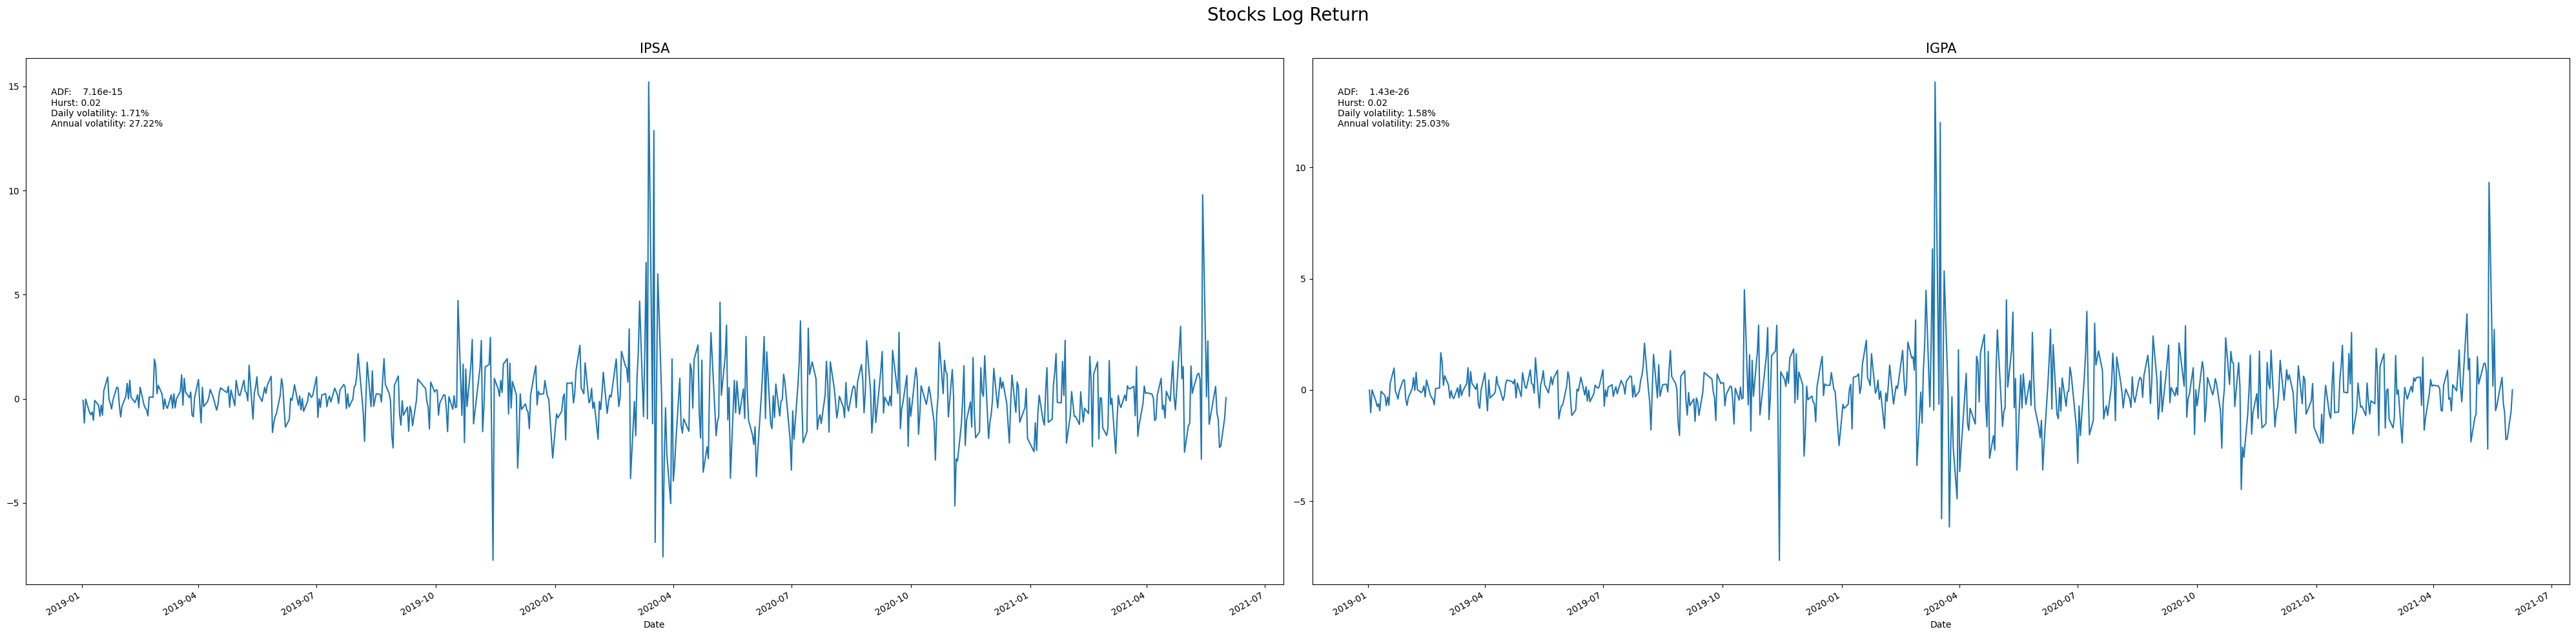

In [8]:
lags=15

lags = min(10, int(len(x)/5)) if lags is None else lags

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40, 10), dpi=100)

for i in range(0,2):
    strC, data = Y[i]

    x = data['Log_Return']

    std_daily = data['Log_Return'].std()        # Calculate daily std of returns
    std_annual = np.sqrt(252) * std_daily  # Convert daily volatility to annaul volatility

    x.plot(ax=axes[i])
    stats = f'ADF: {adfuller(x)[1]:>11.3g} \nHurst: {round(hurst(x.values),2)}\nDaily volatility: {round(std_daily,2)}%\nAnnual volatility: {round(std_annual,2)}%'
    axes[i].text(x=.02, y=.87, s=stats, transform=axes[i].transAxes)
    axes[i].set_title(strC, fontsize=15)

        
fig.suptitle('Stocks Log Return', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)

plt.show()

La figura anterior gráfica el logaritmo de los retornos para cada una de las dos series, el valor del test de _Dickey-Fuller aumentado_ (ADF), el _Hurst Exponent_, y la volatilidad diaria y anual.

#### Aplicación del test Dickey-Fuller 🔴

La aplicación del test sobre los índices bursátiles __IPSA__ e __IGPA__ obtuvo un _p-value_ respectivo de `7.16e-15` y `1.43e-26`. Se consideró un _nivel de significancia_ del $5\%(0.05)$ para rechazar el test, obteniendo en los dos casos valores mucho menores al $5\%$, por lo que en todos los casos se rechazó la hipótesis del test, concluyendo que todas las series son estacionarias.

#### Obtención del _Hurst Exponent_
Para las dos series se obtuvo el _Hurst Exponent_, obteniendo un valor de `0.02` tanto para __IPSA__ como para __IGPA__. De este modo, las dos series presentan un comportamiento de _Mean reversion_ según su valor del _Hurst Exponent_, lo que indicaría que los precios tenderán a converger al precio promedio a lo largo del tiempo.

#### Volatilidad 
La volatilidad de las series fue calcula como la desviación estándar del retorno para el caso diario, mientras que para el caso anual, se calculó como la multiplicación entre la  volatilidad diaria de la serie por el [_Ratio de Sharpe_](https://jpm.pm-research.com/content/21/1/49.full.pdf)($\sqrt{252}$) equivalente a los 252 días hábiles del año. Ambas series presentaron volatilidades similares.

### Noticias de emol.com 🔴

Se obtuvieron 2.521 noticias indexadas de la pagina (emol.com/economia/) del periódico _El Mercurio_. Al igual que las series de tiempo de los índices bursátiles anteriores, se considero el rango de fechas desde __2019-01-01__ hasta __2021-06-01__ para obtener las noticias. Por cada noticia se consideró el cuerpo principal y el titulo de esta. Cada cuerpo y título fueron preprocesados utilizando [Conditional Masked Language Modeling](https://aclanthology.org/2021.emnlp-main.502/) para luego generar sus _embeddings_ utilizando el _encoder_ de [Language-agnostic BERT Sentence Embedding](https://arxiv.org/abs/2007.01852).

#### Conditional Masked Language Modeling 🔴
CMLM es un modelo _no supervisado_ capaz de aprender sentencias a gran escala desde corporas no etiquetados. El modelo aprende de manera efectiva la representación a nivel de __nivel de sentencias__ en orden de obtener un buen MLM score.

<center><img src="https://drive.google.com/uc?export=view&id=1MdF4Z-TyB_Im-zC_kOrCLw6Sboc1Lq2d"></center>

#### Language-agnostic BERT Sentence Embedding 🔴
Modelo entrenado para embeddings a __nivel de sentencias__ metalenguajes utilizando __Mask Language Modeling__ (MLM) y el encoder pre entrenado de __Translation Language Model__ (TLM)(Conneau and Lample, 2019). El modelo utiliza un doble enconder los cuales son entrenados de forma cruzada(_cross-lingual_). Primero, cada sentencia es codificada de forma separada por cada encoder (BERT), para luego entrar a una capa final la cual toma los embeddings de los encoders anteriores y pondera la similaridad coseno entre ellos.

<center><img src="https://1.bp.blogspot.com/-2m5u8cCre6g/XzwldoUhZVI/AAAAAAAAGaE/5gjnSRA1nh8UZ1tTRPp7lmBPBH7Jim-7QCLcBGAsYHQ/s616/image3%2B-%2BEdited%2B%25281%2529.png"></center>

In [9]:
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/LaBSE/2")

In [10]:
emol_news = pd.read_csv('data/post_parser_emol_news.csv').drop(['bajada','permalink'],axis=1)
emol_news['fechaPublicacion'] = pd.to_datetime(emol_news['fechaPublicacion'])
emol_news = emol_news[(emol_news['fechaPublicacion'] >= start) & (emol_news['fechaPublicacion'] <= end)]

#### Porqué el promedio ?

Dado que un día puede tener muchas noticias, se considera el promedio de los _embeddings_  de cada día, ya que el promedio da una regularización de la direcciones vectoriales de todos los _embeddings_.

In [11]:
just_few_news = list(emol_news.groupby([emol_news['fechaPublicacion'].dt.date]))[0][1]

In [12]:
just_few_news

,fechaPublicacion,titulo,texto
3016,2019-01-02,"Tras recibir 150 reclamos, el Sernac ofició a ...",SANTIAGO.- El Sernac (Servicio Nacional del Co...
3017,2019-01-02,Felipe Larraín es elegido por revista inglesa ...,"SANTIAGO.- El titular de Hacienda, Felipe Larr..."
3018,2019-01-02,Presidentes del Senado y la Cámara de Diputado...,"SANTIAGO.- La presidenta de la Cámara, Maya Fe..."


In [13]:
just_few_titles = tf.constant(just_few_news['titulo'].values)
just_few_bodies = tf.constant(just_few_news['texto'].values)

In [14]:
embs_few_titles = encoder(preprocessor(just_few_titles))["default"] 
embs_few_bodies= encoder(preprocessor(just_few_bodies))["default"] 

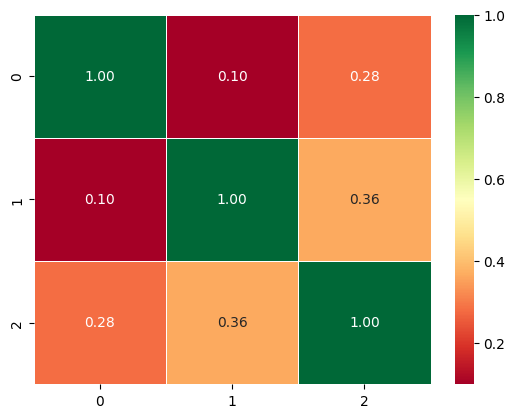

In [15]:
sns.heatmap(cosine_similarity(normalization(embs_few_titles)), linewidth=0.5, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

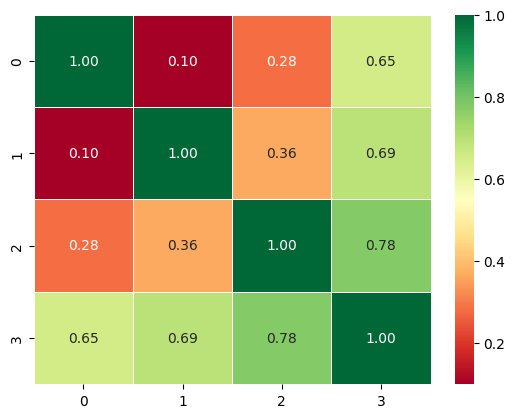

In [16]:
sns.heatmap(cosine_similarity(tf.concat([normalization(embs_few_titles), normalization(embs_few_titles).numpy().mean(0).reshape(1,-1)], 0)), linewidth=0.5, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

#### Embeddings emol.com

##### Por Cuerpo

In [17]:
embeds_body_by_day = dict()

for day_i, df_i in list(emol_news.groupby([emol_news['fechaPublicacion'].dt.date])):
    news_documents = tf.constant(df_i['texto'].values)
    vec_embs_i = encoder(preprocessor(news_documents))["default"]
    
    embeds_body_by_day[day_i] = normalization(vec_embs_i.numpy().mean(0).reshape(1,-1))

##### Por Titulo

In [18]:
embeds_title_by_day = dict()

for day_i, df_i in list(emol_news.groupby([emol_news['fechaPublicacion'].dt.date])):
    news_documents = tf.constant(df_i['titulo'].values)
    vec_embs_i = encoder(preprocessor(news_documents))["default"] 
    
    embeds_title_by_day[day_i] = normalization(vec_embs_i.numpy().mean(0).reshape(1,-1))

### Combinaciones de datos

In [19]:
dates_inter_news_sp = set(pd.to_datetime(list(embeds_body_by_day.keys()))) & set(pd.to_datetime(list(embeds_title_by_day.keys()))) & set(ipsa_ts.index) & set(igpa_ts.index)

In [20]:
igpa_ts = igpa_ts[igpa_ts.index.isin(dates_inter_news_sp)]
ipsa_ts = ipsa_ts[ipsa_ts.index.isin(dates_inter_news_sp)]

In [21]:
for date_i in list(embeds_body_by_day.keys()):
    if pd.to_datetime(date_i) not in dates_inter_news_sp:
        del embeds_body_by_day[date_i]

In [22]:
for date_i in list(embeds_title_by_day.keys()):
    if pd.to_datetime(date_i) not in dates_inter_news_sp:
        del embeds_title_by_day[date_i]

In [23]:
X = [('embeds_body_by_day',np.array([i[1] for i in sorted(embeds_body_by_day.items(), key=lambda tup: tup[0])])), ('embeds_title_by_day',np.array([i[1] for i in sorted(embeds_body_by_day.items(), key=lambda tup: tup[0])]))]
Y = [('IPSA',ipsa_ts), ('IGPA',igpa_ts)]

## Diseño Experimental

Para el desarrollo del diseño experimental, se utilizo el diccionario global `dict_simul` que contiene los modelos `classical` (ARMA, ARCH, Prophet, Residuals ARMA-ARCH) y `rnn` (LSTM Base, LABSE-body-BiLSTM, LABSE-title-BiLSTM, Ryo Akita et. al. Model, y Xinyi Li et. al. Model) 🔴

In [24]:
dict_simul = {'classical': {}}

In [25]:
for strC, data in Y:
    dict_simul['classical'][strC] = {}
    
    dict_simul['classical'][strC]['data'] = data['Log_Return']
    
    aux_data = data['Log_Return'].values.reshape(1, -1)[0]
    
    for d_i in ['7','14']:
        dict_simul['classical'][strC][d_i] = {}
        dict_simul['classical'][strC][d_i]['train_data'], dict_simul['classical'][strC][d_i]['test_data'] = aux_data[:-int(d_i)], aux_data[-int(d_i):]

In [26]:
for strC, _ in Y:
    for d_i in ['7','14']:
        print(strC, dict_simul['classical'][strC]['data'].shape, dict_simul['classical'][strC][d_i]['train_data'].shape, dict_simul['classical'][strC][d_i]['test_data'].shape)

IPSA (563,) (556,) (7,)
IPSA (563,) (549,) (14,)
IGPA (563,) (556,) (7,)
IGPA (563,) (549,) (14,)


### Modelos Clásicos 🔴

#### ARMA 🔴

In [27]:
for strC, _ in Y:
    for d_i in ['7','14']:
        dict_simul['classical'][strC][d_i]['model_autoARIMA'] = auto_arima(dict_simul['classical'][strC][d_i]['train_data'], start_p=1, start_q=1,
                                                                          test='adf',       #type of root test
                                                                          max_p=5, max_q=5, #max_p is the max value of AR and max_q is the max value of MA
                                                                          #m=1,              #annual data
                                                                          d=None, #d=None,           
                                                                          seasonal=False,
                                                                          #D=10,
                                                                          #max_D=10,
                                                                          trace=True,
                                                                          #information_criterion='bic', # used to select best model
                                                                          error_action='ignore',  
                                                                          suppress_warnings=True, 
                                                                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2181.138, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2183.235, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2184.449, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2184.672, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2163.868, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2164.650, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2165.512, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2163.879, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2162.315, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2165.402, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2164.206, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2163.803, Time=0.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2165.038, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2164.069, Time=0.08 sec

Best model:  ARIMA(1,0,2)(0,0,0)

#### ARCH 🔴

In [28]:
for strC, _ in Y:
    for d_i in ['7','14']:
        Ap,_,Aq = dict_simul['classical'][strC][d_i]['model_autoARIMA'].to_dict()['order']

        if Ap==0:
            Ap=1
        if Aq==0:
            Aq=1
    
        # Specify GARCH model assumptions
        dict_simul['classical'][strC][d_i]['arch_model'] = arch_model(dict_simul['classical'][strC][d_i]['train_data'], p = Ap, q = Aq, mean = 'constant', vol = 'GARCH', dist = 'normal', rescale=False)
    
        # Fit the model
        dict_simul['classical'][strC][d_i]['arch_model_result'] = dict_simul['classical'][strC][d_i]['arch_model'].fit(update_freq = 7)
        
        #print(dict_simul['classical'][strC][d_i]['arch_model_result'].summary())

Iteration:      7,   Func. Count:     50,   Neg. LLF: 959.7272976831055
Optimization terminated successfully    (Exit mode 0)
            Current function value: 959.7188627075707
            Iterations: 11
            Function evaluations: 73
            Gradient evaluations: 11
Iteration:      7,   Func. Count:     50,   Neg. LLF: 952.6363446968847
Optimization terminated successfully    (Exit mode 0)
            Current function value: 952.6249858085166
            Iterations: 11
            Function evaluations: 73
            Gradient evaluations: 11
Iteration:      7,   Func. Count:     50,   Neg. LLF: 909.2962046905295
Optimization terminated successfully    (Exit mode 0)
            Current function value: 909.2881143457005
            Iterations: 11
            Function evaluations: 73
            Gradient evaluations: 11
Iteration:      7,   Func. Count:     50,   Neg. LLF: 902.9925129262522
Optimization terminated successfully    (Exit mode 0)
            Current function va

#### Prophet 🔴

In [29]:
for strC, data in Y:
    for d_i in ['7','14']:        
        d = pd.DataFrame({'ds': data.dropna().index, 'y': data['Log_Return'].values.reshape(1, -1)[0]})

        train_data, _ = d[:-int(d_i)], d[-int(d_i):]

        dict_simul['classical'][strC][d_i]['model_prophet'] = Prophet().fit(train_data) 

        df = pd.merge(train_data, dict_simul['classical'][strC][d_i]['model_prophet'].predict(), on='ds')
        
        dict_simul['classical'][strC][d_i]['model_prophet_residuals'] = df['yhat'] - df['y']

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Residuals ARMA-ARCH 🔴

In [30]:
for strC, data in Y:
    for d_i in ['7','14']:
        
        Ap,_,Aq = dict_simul['classical'][strC][d_i]['model_autoARIMA'].to_dict()['order']
    
        if Ap==0:
            Ap=1
        if Aq==0:
            Aq=1

        residuals = dict_simul['classical'][strC][d_i]['model_autoARIMA'].resid()

        dict_simul['classical'][strC][d_i]['model_residuals_garch'] = arch_model(residuals, mean='Zero', p=Ap, q=Aq)
        dict_simul['classical'][strC][d_i]['model_residuals_garch_result'] = dict_simul['classical'][strC][d_i]['model_residuals_garch'].fit(disp = 'off')

        #print(dict_simul['classical'][strC][d_i]['model_residuals_garch_result'].summary())

### Modelos Recurrentes 🔴

In [31]:
dict_simul['rnn'] = {}
for strC, data in Y:
    dict_simul['rnn'][strC] = {}
    dict_simul['rnn'][strC]['data'] = data
    for d_i in ['7','14']:
        dict_simul['rnn'][strC][d_i] = {}

for strC, data in X:
    dict_simul['rnn'][strC] = data

In [32]:
neurons = 15
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=2, mode='min')

#### LSTM Base 🔴

In [33]:
sequence_length = 7
batch_size=100
input_dim=1
input_timesteps=6

In [34]:
for strC, _ in Y:
    for d_i in ['7','14']:
        Y_data = dict_simul['rnn'][strC]['data']['Log_Return'].values.reshape(1, -1).T
        
        data_train_1, _ = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        
        len_train  = len(data_train_1)
        len_train_windows = None

        data_windows = []
        for i in range(len_train - sequence_length):
            data_windows.append(data_train_1[i:i+sequence_length])
        data_windows = np.array(data_windows).astype(float)

        window_data=data_windows
        win_num=window_data.shape[0]
        col_num=window_data.shape[2]

        x_train1 = data_windows[:, :-1]
        y_train1 = data_windows[:, -1,[-1]]
        
        dict_simul['rnn'][strC][d_i]['model_LSTM_base'] = Sequential()
        dict_simul['rnn'][strC][d_i]['model_LSTM_base'].add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
        dict_simul['rnn'][strC][d_i]['model_LSTM_base'].add(LSTM(neurons,return_sequences = True))
        dict_simul['rnn'][strC][d_i]['model_LSTM_base'].add(LSTM(neurons,return_sequences =False))
        dict_simul['rnn'][strC][d_i]['model_LSTM_base'].add(Dense(1, activation='linear'))

        dict_simul['rnn'][strC][d_i]['model_LSTM_base'].compile(loss='mean_squared_error', optimizer='adam')
        
        dict_simul['rnn'][strC][d_i]['model_LSTM_base'].fit(x_train1,y_train1,epochs=200,batch_size=batch_size,verbose=0)

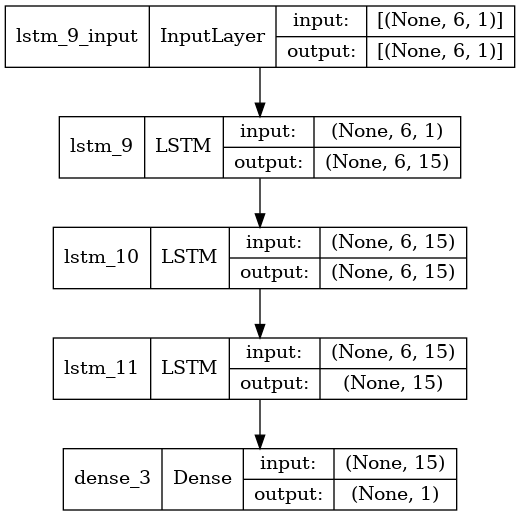

In [35]:
plot_model(dict_simul['rnn'][strC][d_i]['model_LSTM_base'], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### LABSE-body-BiLSTM 🔴

In [36]:
for strC, _ in Y:
    for d_i in ['7','14']:
        Y_data = dict_simul['rnn'][strC]['data']['Log_Return'].values.reshape(1, -1).T
        X_data = dict_simul['rnn']['embeds_body_by_day']
        
        dict_simul['rnn'][strC][d_i]['model_LABSE_body_BiLSTM'] = Sequential()
        dict_simul['rnn'][strC][d_i]['model_LABSE_body_BiLSTM'].add(Bidirectional(GRU(neurons, input_shape = X_data.shape[1:], return_sequences = True)))
        dict_simul['rnn'][strC][d_i]['model_LABSE_body_BiLSTM'].add(Bidirectional(LSTM(neurons,return_sequences = True)))
        dict_simul['rnn'][strC][d_i]['model_LABSE_body_BiLSTM'].add(Bidirectional(LSTM(neurons,return_sequences = False)))
        dict_simul['rnn'][strC][d_i]['model_LABSE_body_BiLSTM'].add(Dense(1))
        
        y_train, _ = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        x_train, _ = X_data[:-int(d_i)], X_data[-int(d_i):]
        
        dict_simul['rnn'][strC][d_i]['model_LABSE_body_BiLSTM'].compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mae"])
        # dict_simul['rnn'][strC][d_i]['model_LABSE_body_BiLSTM_history'] = 
        dict_simul['rnn'][strC][d_i]['model_LABSE_body_BiLSTM'].fit(x_train, y_train, epochs=200, batch_size=30, verbose=0, callbacks=[early_stopping])

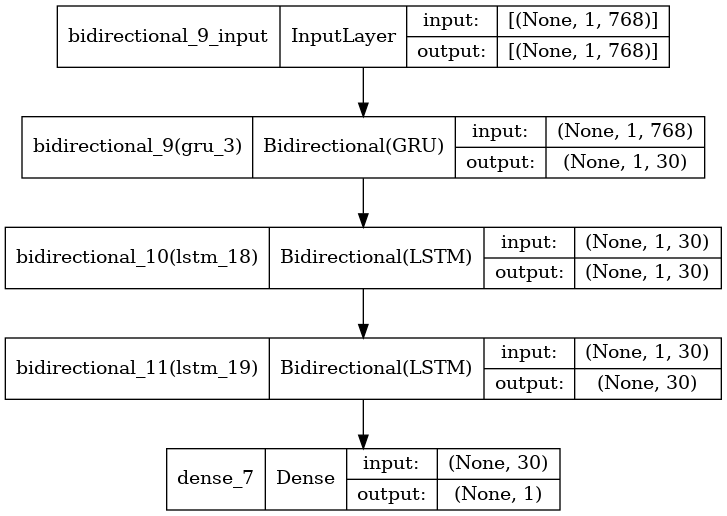

In [37]:
plot_model(dict_simul['rnn'][strC][d_i]['model_LABSE_body_BiLSTM'], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### LABSE-title-BiLSTM 🔴

In [38]:
for strC, _ in Y:
    for d_i in ['7','14']:
        Y_data = dict_simul['rnn'][strC]['data']['Log_Return'].values.reshape(1, -1).T
        X_data = dict_simul['rnn']['embeds_title_by_day']
        
        dict_simul['rnn'][strC][d_i]['model_LABSE_title_BiLSTM'] = Sequential()
        dict_simul['rnn'][strC][d_i]['model_LABSE_title_BiLSTM'].add(Bidirectional(GRU(neurons, input_shape = X_data.shape[1:], return_sequences = True)))
        dict_simul['rnn'][strC][d_i]['model_LABSE_title_BiLSTM'].add(Bidirectional(LSTM(neurons,return_sequences = True)))
        dict_simul['rnn'][strC][d_i]['model_LABSE_title_BiLSTM'].add(Bidirectional(LSTM(neurons,return_sequences = False)))
        dict_simul['rnn'][strC][d_i]['model_LABSE_title_BiLSTM'].add(Dense(1))
        
        y_train, _ = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        x_train, _ = X_data[:-int(d_i)], X_data[-int(d_i):]
        
        dict_simul['rnn'][strC][d_i]['model_LABSE_title_BiLSTM'].compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mae"])
        dict_simul['rnn'][strC][d_i]['model_LABSE_title_BiLSTM'].fit(x_train, y_train, epochs=200, batch_size=30, verbose=0, callbacks=[early_stopping])

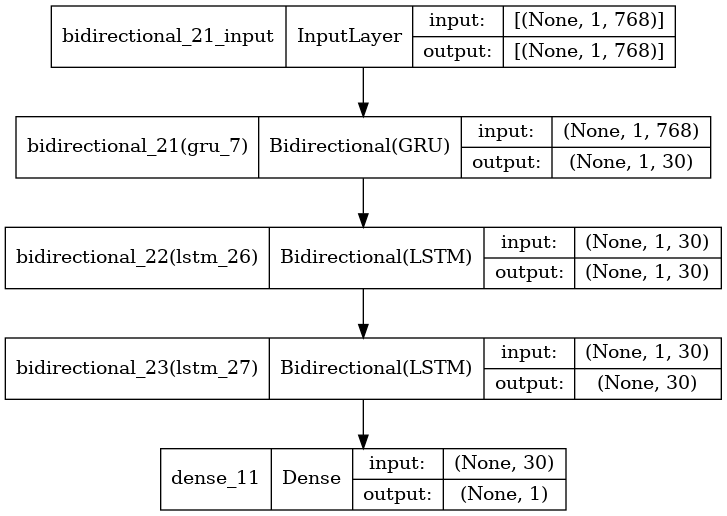

In [39]:
plot_model(dict_simul['rnn'][strC][d_i]['model_LABSE_title_BiLSTM'], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### [Ryo Akita et. al. Model](https://ieeexplore.ieee.org/document/7550882) 🔴
Modelo que utiliza el clasificador de sentimientos _VADER_ sobre los títulos de noticias para entrenar un modelo recurrente. Dado que _VADER_ [no esta entrenado para multilenguaje](https://stackoverflow.com/questions/45275166/is-vader-sentimentintensityanalyzer-multilingual), se utilizó el clasificador de [pysentimento](https://arxiv.org/abs/2106.09462) ([github](https://github.com/pysentimiento/pysentimiento)). 

In [40]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

In [41]:
news_df = emol_news[['fechaPublicacion','titulo']]

dates_inter_news_df = set(pd.to_datetime(emol_news['fechaPublicacion'].values)) & set(ipsa_ts.index) & set(igpa_ts.index)

news_df = news_df[news_df['fechaPublicacion'].isin(dates_inter_news_df)]

ditc_ipsa = ipsa_ts['Log_Return'].to_dict()
ditc_igpa = igpa_ts['Log_Return'].to_dict()

In [42]:
dict_dateset = {'neg':[], 'neu':[], 'pos':[], 'ipsa':[], 'igpa':[]}
for index, row in news_df.iterrows():
    date = pd.to_datetime(row['fechaPublicacion'])
    text = row['titulo']
    
    neg, neu, pos = tuple(analyzer.predict(text).probas.values())
    log_ret_ipsa = ditc_ipsa[date]
    log_ret_igpa = ditc_igpa[date]
    
    dict_dateset['neg'].append(neg)
    dict_dateset['neu'].append(neu)
    dict_dateset['pos'].append(pos)
    dict_dateset['ipsa'].append(log_ret_ipsa)
    dict_dateset['igpa'].append(log_ret_igpa)

df_dataset = pd.DataFrame(dict_dateset).iloc[::-1]

In [43]:
dict_simul['rnn']['akita'] = {}
dict_simul['rnn']['akita']['IPSA'] = {}
dict_simul['rnn']['akita']['IGPA'] = {}

dict_simul['rnn']['akita']['IPSA']['data'] = df_dataset.values[:, [3]]
dict_simul['rnn']['akita']['IGPA']['data'] = df_dataset.values[:, [4]]
dict_simul['rnn']['akita']['X'] = df_dataset.values[:, [0,1,2]]

In [44]:
for strC, _ in Y:
    for d_i in ['7','14']:
        X_data = dict_simul['rnn']['akita']['X']
        X_data = np.expand_dims(X_data, axis=1)
        
        Y_data = dict_simul['rnn']['akita'][strC]['data'] 
        
        dict_simul['rnn']['akita'][strC]['model'] = Sequential()
        dict_simul['rnn']['akita'][strC]['model'].add(LSTM(48, input_shape = [1,3]))
        dict_simul['rnn']['akita'][strC]['model'].add(Dropout(0.8))
        dict_simul['rnn']['akita'][strC]['model'].add(Dense(1))
        
        dict_simul['rnn']['akita'][strC]['model'].compile(loss='mean_squared_error', optimizer='adam')
        
        y_train, _ = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        x_train, _ = X_data[:-int(d_i)], X_data[-int(d_i):]
                

        dict_simul['rnn']['akita'][strC]['model'].fit(x_train, y_train, epochs = 40, batch_size = 64, verbose=0)

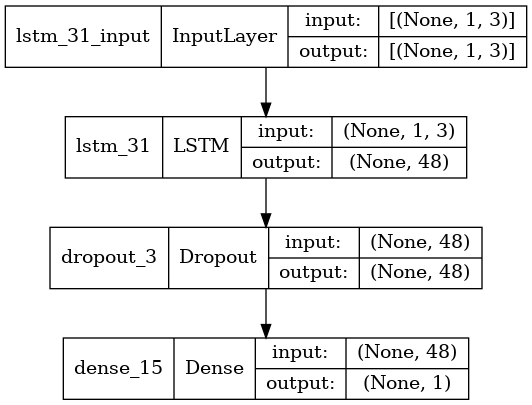

In [45]:
plot_model(dict_simul['rnn']['akita'][strC]['model'], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### [Xinyi Li et. al. Model](https://arxiv.org/pdf/1912.10806.pdf) 🔴
 _VADER_ + ARMA Residual

In [46]:
dict_simul['rnn']['xinyi'] = {}
dict_simul['rnn']['xinyi']['IPSA'] = {}
dict_simul['rnn']['xinyi']['IGPA'] = {}

neurons=50
dense_output=1
drop_out=0

In [47]:
for strC, _ in Y:
    for d_i in ['7','14']:
        X_data = dict_simul['rnn']['akita']['X']
        X_data = np.expand_dims(X_data, axis=1)
        
        Y_data = dict_simul['rnn']['akita'][strC]['data']
        
        aux_arma_model = auto_arima(Y_data, start_p=1, start_q=1, 
                                    test='adf', max_p=5, max_q=5,d=None, seasonal=False,
                                    trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)
        
        residuals = np.expand_dims(np.array(aux_arma_model.resid()).reshape(-1,1), axis=1)
        
        X_data = np.concatenate((X_data, residuals) , axis=2)
                             
        dict_simul['rnn']['xinyi'][strC]['model'] = Sequential()
        dict_simul['rnn']['xinyi'][strC]['model'].add(LSTM(neurons, input_shape=[1,4], return_sequences = True))
        dict_simul['rnn']['xinyi'][strC]['model'].add(Dropout(drop_out))
        dict_simul['rnn']['xinyi'][strC]['model'].add(LSTM(neurons,return_sequences = True))
        dict_simul['rnn']['xinyi'][strC]['model'].add(LSTM(neurons,return_sequences =False))
        dict_simul['rnn']['xinyi'][strC]['model'].add(Dropout(drop_out))
        dict_simul['rnn']['xinyi'][strC]['model'].add(Dense(dense_output, activation='linear'))
        
        dict_simul['rnn']['xinyi'][strC]['model'].compile(loss='mean_squared_error', optimizer='adam')
        
        y_train, _ = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        x_train, _ = X_data[:-int(d_i)], X_data[-int(d_i):]
                

        dict_simul['rnn']['xinyi'][strC]['model'].fit(x_train, y_train, epochs = 6, batch_size = 100, verbose=0)

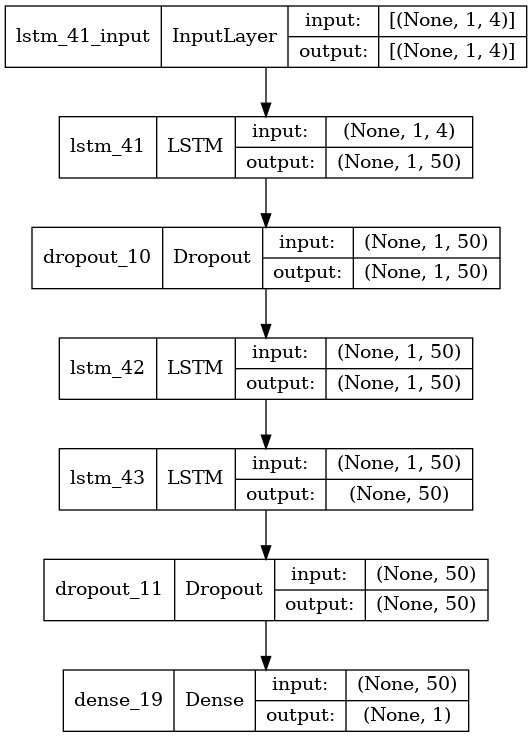

In [48]:
plot_model(dict_simul['rnn']['xinyi'][strC]['model'], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Resultados

In [49]:
index_model_ = []
mse_model_ = []
mae_model_ = []

for strC, _ in Y:
    for d_i in ['7','14']:
        Ap,_,Aq = dict_simul['classical'][strC][d_i]['model_autoARIMA'].to_dict()['order']
        
        model_str = 'ARMA('+str(Ap)+','+str(Aq)+') ' + strC + ' ' + d_i + '-Days'
        
        preds, _ = dict_simul['classical'][strC][d_i]['model_autoARIMA'].predict(n_periods=dict_simul['classical'][strC][d_i]['test_data'].shape[0],return_conf_int=True)
        
        mse = round(mean_squared_error(dict_simul['classical'][strC][d_i]['test_data'], preds),5)
        mae = round(mean_absolute_error(dict_simul['classical'][strC][d_i]['test_data'], preds),5)
        
        index_model_.append(model_str)
        mse_model_.append(mse)
        mae_model_.append(mae)
        
for strC, _ in Y:
    for d_i in ['7','14']:
        Ap,_,Aq = dict_simul['classical'][strC][d_i]['model_autoARIMA'].to_dict()['order']
        
        model_str = 'ARCH('+str(Ap)+','+str(Aq)+') ' + strC + ' ' + d_i + '-Days'
        
        gm_forecast = dict_simul['classical'][strC][d_i]['arch_model_result'].forecast(horizon = dict_simul['classical'][strC][d_i]['test_data'].shape[0])

        mse = round(mean_squared_error(dict_simul['classical'][strC][d_i]['test_data'], gm_forecast.variance[-1:].values[0]),5)
        mae = round(mean_absolute_error(dict_simul['classical'][strC][d_i]['test_data'], gm_forecast.variance[-1:].values[0]),5)
        
        index_model_.append(model_str)
        mse_model_.append(mse)
        mae_model_.append(mae)
        
for strC, data in Y:
    for d_i in ['7','14']:
        
        model_str = 'Prophet ' + strC + ' ' + d_i + '-Days'
    
        d = pd.DataFrame({'ds': data.dropna().index, 'y': data['Log_Return'].values.reshape(1, -1)[0]})
        
        _, test_data = d[:-int(d_i)], d[-int(d_i):]

        future = dict_simul['classical'][strC][d_i]['model_prophet'].predict(test_data)
        
        mse = round(mean_squared_error(dict_simul['classical'][strC][d_i]['test_data'],future['yhat']),5)
        mae = round(mean_absolute_error(dict_simul['classical'][strC][d_i]['test_data'],future['yhat']),5)
        
        index_model_.append(model_str)
        mse_model_.append(mse)
        mae_model_.append(mae)
        
for strC, data in Y:
    for d_i in ['7','14']:
        
        model_str = 'Residual ARMA-ARCH ' + strC + ' ' + d_i + '-Days'
        
        gm_forecast = dict_simul['classical'][strC][d_i]['model_residuals_garch_result'].forecast(horizon = dict_simul['classical'][strC][d_i]['test_data'].shape[0])
        
        mse = round(mean_squared_error(dict_simul['classical'][strC][d_i]['test_data'], gm_forecast.variance[-1:].values[0]),5)
        mae = round(mean_absolute_error(dict_simul['classical'][strC][d_i]['test_data'], gm_forecast.variance[-1:].values[0]),5)
        
        index_model_.append(model_str)
        mse_model_.append(mse)
        mae_model_.append(mae)
        
for strC, _ in Y:
    for d_i in ['7','14']:
        
        model_str = 'LSMT Base ' + strC + ' ' + d_i + '-Days'
        
        Y_data = dict_simul['rnn'][strC]['data']['Log_Return'].values.reshape(1, -1).T
        
        _, test_data_1 = Y_data[:-int(d_i) - sequence_length], Y_data[-int(d_i) - sequence_length:]
        
        len_test = len(test_data_1)
        len_train_windows = None

        data_windows = []
        for i in range(len_test - sequence_length):
            data_windows.append(test_data_1[i:i+sequence_length])

        data_windows = np.array(data_windows).astype(float)
        
        x_test = data_windows[:, :-1]
        y_test = data_windows[:, -1, [0]]

        pred = dict_simul['rnn'][strC][d_i]['model_LSTM_base'].predict(x_test)
        
        mse = round(mean_squared_error(y_test, pred),5)
        mae = round(mean_absolute_error(y_test, pred),5)
    
        index_model_.append(model_str)
        mse_model_.append(mse)
        mae_model_.append(mae)
        
for strC, _ in Y:
    for d_i in ['7','14']:
        
        model_str = 'LABSE-body-BiLSTM ' + strC + ' ' + d_i + '-Days'
        
        Y_data = dict_simul['rnn'][strC]['data']['Log_Return'].values.reshape(1, -1).T
        X_data = dict_simul['rnn']['embeds_body_by_day']
        
        _, y_test = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        _, x_test = X_data[:-int(d_i)], X_data[-int(d_i):]
        
                
        pred = dict_simul['rnn'][strC][d_i]['model_LABSE_body_BiLSTM'].predict(x_test)
        
        mse = round(mean_squared_error(y_test, pred),5)
        mae = round(mean_absolute_error(y_test, pred),5)
        
        index_model_.append(model_str)
        mse_model_.append(mse)
        mae_model_.append(mae)
        
for strC, _ in Y:
    for d_i in ['7','14']:
        
        model_str = 'LABSE-title-BiLSTM ' + strC + ' ' + d_i + '-Days'
        
        Y_data = dict_simul['rnn'][strC]['data']['Log_Return'].values.reshape(1, -1).T
        X_data = dict_simul['rnn']['embeds_title_by_day']
        
        _, y_test = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        _, x_test = X_data[:-int(d_i)], X_data[-int(d_i):]
        
                
        pred = dict_simul['rnn'][strC][d_i]['model_LABSE_title_BiLSTM'].predict(x_test)
        
        mse = round(mean_squared_error(y_test, pred),5)
        mae = round(mean_absolute_error(y_test, pred),5)
        
        index_model_.append(model_str)
        mse_model_.append(mse)
        mae_model_.append(mae)
        
for strC, _ in Y:
    for d_i in ['7','14']:
        
        model_str = 'Ryo Akita et. al. Model ' + strC + ' ' + d_i + '-Days'
        
        X_data = dict_simul['rnn']['akita']['X']
        X_data = np.expand_dims(X_data, axis=1)
        
        Y_data = dict_simul['rnn']['akita'][strC]['data'] 
        
        _, y_test = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        _, x_test = X_data[:-int(d_i)], X_data[-int(d_i):]
        
                
        pred = dict_simul['rnn']['akita'][strC]['model'].predict(x_test)
        
        mse = round(mean_squared_error(y_test, pred),5)
        mae = round(mean_absolute_error(y_test, pred),5)
        
        index_model_.append(model_str)
        mse_model_.append(mse)
        mae_model_.append(mae)

for strC, _ in Y:
    for d_i in ['7','14']:
        
        model_str = 'Xinyi Li et. al. Model ' + strC + ' ' + d_i + '-Days'
        
        X_data = dict_simul['rnn']['akita']['X']
        X_data = np.expand_dims(X_data, axis=1)
        
        Y_data = dict_simul['rnn']['akita'][strC]['data']
        
        aux_arma_model = auto_arima(Y_data, start_p=1, start_q=1, 
                                    test='adf', max_p=5, max_q=5,d=None, seasonal=False,
                                    trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)
        
        residuals = np.expand_dims(np.array(aux_arma_model.resid()).reshape(-1,1), axis=1)
        
        X_data = np.concatenate((X_data, residuals) , axis=2)
        
        _, y_test = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        _, x_test = X_data[:-int(d_i)], X_data[-int(d_i):]
        
                
        pred = dict_simul['rnn']['xinyi'][strC]['model'].predict(x_test)
        
        mse = round(mean_squared_error(y_test, pred),5)
        mae = round(mean_absolute_error(y_test, pred),5)
        
        index_model_.append(model_str)
        mse_model_.append(mse)
        mae_model_.append(mae)

In [50]:
p_val = 0.05 ## 5%

p_vals_model_ = []

for strC, _ in Y:
    for d_i in ['7','14']:
        Ap,_,Aq = dict_simul['classical'][strC][d_i]['model_autoARIMA'].to_dict()['order']
        model_str = 'ARMA('+str(Ap)+','+str(Aq)+') ' + strC + ' ' + d_i + '-Days'

        m_residuals = dict_simul['classical'][strC][d_i]['model_autoARIMA'].resid()


        # Perform the Ljung-Box test
        lb_test = acorr_ljungbox(m_residuals , lags = 10, return_df=False)

        # Store p-values in DataFrame
        df = pd.DataFrame({model_str: lb_test[1]}).T

        # Create column names for each lag
        col_num = df.shape[1]
        col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

        # Display the p-values
        df.columns = col_names
        p_vals_model_.append(df)

for strC, _ in Y:
    for d_i in ['7','14']:
        Ap,_,Aq = dict_simul['classical'][strC][d_i]['model_autoARIMA'].to_dict()['order']
        
        model_str = 'ARCH('+str(Ap)+','+str(Aq)+') ' + strC + ' ' + d_i + '-Days'

        m_residuals = dict_simul['classical'][strC][d_i]['arch_model_result'].resid


        # Perform the Ljung-Box test
        lb_test = acorr_ljungbox(m_residuals , lags = 10, return_df=False)

        # Store p-values in DataFrame
        df = pd.DataFrame({model_str: lb_test[1]}).T

        # Create column names for each lag
        col_num = df.shape[1]
        col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

        # Display the p-values
        df.columns = col_names
        p_vals_model_.append(df)
        
for strC, data in Y:
    for d_i in ['7','14']:
        model_str = 'Prophet ' + strC + ' ' + d_i + '-Days'

        d = pd.DataFrame({'ds': data.dropna().index, 'y': data['Log_Return'].values.reshape(1, -1)[0]})

        train_data, test_data = d[:-int(d_i)], d[-int(d_i):]


        df = pd.merge(train_data, dict_simul['classical'][strC][d_i]['model_prophet'].predict(), on='ds')
        dict_simul['classical'][strC][d_i]['model_prophet_residuals'] = df['yhat'] - df['y']

        # Perform the Ljung-Box test
        lb_test = acorr_ljungbox(dict_simul['classical'][strC][d_i]['model_prophet_residuals'] , lags = 10, return_df=False)

        # Store p-values in DataFrame
        df = pd.DataFrame({model_str: lb_test[1]}).T

        # Create column names for each lag
        col_num = df.shape[1]
        col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

        # Display the p-values
        df.columns = col_names
        p_vals_model_.append(df)
        
for strC, _ in Y:
    for d_i in ['7','14']:
        model_str = 'Residual ARMA-ARCH ' + strC + ' ' + d_i + '-Days'

        m_residuals = dict_simul['classical'][strC][d_i]['model_residuals_garch_result'].resid


        # Perform the Ljung-Box test
        lb_test = acorr_ljungbox(m_residuals , lags = 10, return_df=False)

        # Store p-values in DataFrame
        df = pd.DataFrame({model_str: lb_test[1]}).T

        # Create column names for each lag
        col_num = df.shape[1]
        col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

        # Display the p-values
        df.columns = col_names
        p_vals_model_.append(df)
        
for strC, _ in Y:
    for d_i in ['7','14']:
        
        model_str = 'LSMT Base ' + strC + ' ' + d_i + '-Days'
        
        Y_data = dict_simul['rnn'][strC]['data']['Log_Return'].values.reshape(1, -1).T
        
        data_train_1, _ = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        
        len_train  = len(data_train_1)
        len_train_windows = None

        data_windows = []
        for i in range(len_train - sequence_length):
            data_windows.append(data_train_1[i:i+sequence_length])
        data_windows = np.array(data_windows).astype(float)

        window_data=data_windows
        win_num=window_data.shape[0]
        col_num=window_data.shape[2]

        x_train1 = data_windows[:, :-1]
        y_train1 = data_windows[:, -1,[-1]]

        pred = dict_simul['rnn'][strC][d_i]['model_LSTM_base'].predict(x_train1)

        preds_lstm_residual = np.expm1(y_train1) - np.expm1(pred)

        # Perform the Ljung-Box test
        lb_test = acorr_ljungbox(preds_lstm_residual , lags = 10, return_df=False)

        # Store p-values in DataFrame
        df = pd.DataFrame({model_str: lb_test[1]}).T

        # Create column names for each lag
        col_num = df.shape[1]
        col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

        # Display the p-values
        df.columns = col_names
        p_vals_model_.append(df)

for strC, _ in Y:
    for d_i in ['7','14']:
        
        model_str = 'LABSE-body-BiLSTM ' + strC + ' ' + d_i + '-Days'
        
        Y_data = dict_simul['rnn'][strC]['data']['Log_Return'].values.reshape(1, -1).T
        X_data = dict_simul['rnn']['embeds_body_by_day']
        
        y_train, _ = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        x_train, _ = X_data[:-int(d_i)], X_data[-int(d_i):]
        
                
        pred = dict_simul['rnn'][strC][d_i]['model_LABSE_body_BiLSTM'].predict(x_train)
        
        preds_lstm_residual = np.expm1(y_train) - np.expm1(pred)

        # Perform the Ljung-Box test
        lb_test = acorr_ljungbox(preds_lstm_residual , lags = 10, return_df=False)

        # Store p-values in DataFrame
        df = pd.DataFrame({model_str: lb_test[1]}).T

        # Create column names for each lag
        col_num = df.shape[1]
        col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

        # Display the p-values
        df.columns = col_names
        p_vals_model_.append(df)
        
for strC, _ in Y:
    for d_i in ['7','14']:
        
        model_str = 'LABSE-title-BiLSTM ' + strC + ' ' + d_i + '-Days'
        
        Y_data = dict_simul['rnn'][strC]['data']['Log_Return'].values.reshape(1, -1).T
        X_data = dict_simul['rnn']['embeds_title_by_day']
        
        y_train, _ = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        x_train, _ = X_data[:-int(d_i)], X_data[-int(d_i):]
        
                
        pred = dict_simul['rnn'][strC][d_i]['model_LABSE_title_BiLSTM'].predict(x_train)
        
        preds_lstm_residual = np.expm1(y_train) - np.expm1(pred)

        # Perform the Ljung-Box test
        lb_test = acorr_ljungbox(preds_lstm_residual , lags = 10, return_df=False)

        # Store p-values in DataFrame
        df = pd.DataFrame({model_str: lb_test[1]}).T

        # Create column names for each lag
        col_num = df.shape[1]
        col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

        # Display the p-values
        df.columns = col_names
        p_vals_model_.append(df)
        
for strC, _ in Y:
    for d_i in ['7','14']:
        
        model_str = 'Ryo Akita et. al. Model ' + strC + ' ' + d_i + '-Days'
        
        X_data = dict_simul['rnn']['akita']['X']
        X_data = np.expand_dims(X_data, axis=1)
        
        Y_data = dict_simul['rnn']['akita'][strC]['data'] 
        
        y_train, _ = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        x_train, _ = X_data[:-int(d_i)], X_data[-int(d_i):]
        
                
        pred = dict_simul['rnn']['akita'][strC]['model'].predict(x_train)
        
        
        preds_lstm_residual = np.expm1(y_train) - np.expm1(pred)

        # Perform the Ljung-Box test
        lb_test = acorr_ljungbox(preds_lstm_residual , lags = 10, return_df=False)

        # Store p-values in DataFrame
        df = pd.DataFrame({model_str: lb_test[1]}).T

        # Create column names for each lag
        col_num = df.shape[1]
        col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

        # Display the p-values
        df.columns = col_names
        p_vals_model_.append(df)
        
for strC, _ in Y:
    for d_i in ['7','14']:
        
        model_str = 'Xinyi Li et. al. Model ' + strC + ' ' + d_i + '-Days'
        
        X_data = dict_simul['rnn']['akita']['X']
        X_data = np.expand_dims(X_data, axis=1)
        
        Y_data = dict_simul['rnn']['akita'][strC]['data']
        
        aux_arma_model = auto_arima(Y_data, start_p=1, start_q=1, 
                                    test='adf', max_p=5, max_q=5,d=None, seasonal=False,
                                    trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)
        
        residuals = np.expand_dims(np.array(aux_arma_model.resid()).reshape(-1,1), axis=1)
        
        X_data = np.concatenate((X_data, residuals) , axis=2)
        
        y_train, _ = Y_data[:-int(d_i)], Y_data[-int(d_i):]
        x_train, _ = X_data[:-int(d_i)], X_data[-int(d_i):]
        
                
        pred = dict_simul['rnn']['xinyi'][strC]['model'].predict(x_train)
        
        
        preds_lstm_residual = np.expm1(y_train) - np.expm1(pred)

        # Perform the Ljung-Box test
        lb_test = acorr_ljungbox(preds_lstm_residual , lags = 10, return_df=False)

        # Store p-values in DataFrame
        df = pd.DataFrame({model_str: lb_test[1]}).T

        # Create column names for each lag
        col_num = df.shape[1]
        col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

        # Display the p-values
        df.columns = col_names
        p_vals_model_.append(df)

## Comparaciones MAE / MSE 🔴

In [51]:
pd.DataFrame(data={'MSE': mse_model_, 'MAE': mae_model_}, index= index_model_).sort_values(by=['MSE', 'MAE'])

,MSE,MAE
Xinyi Li et. al. Model IPSA 7-Days,0.11523,0.26430
Xinyi Li et. al. Model IGPA 7-Days,0.13922,0.28858
Prophet IGPA 7-Days,0.18525,0.36523
Prophet IPSA 7-Days,0.22289,0.39312
Ryo Akita et. al. Model IPSA 7-Days,0.24604,0.28498
LSMT Base IGPA 14-Days,0.25213,0.40800
Ryo Akita et. al. Model IGPA 7-Days,0.26920,0.28357
"ARMA(1,2) IGPA 14-Days",0.30159,0.44332
LABSE-title-BiLSTM IGPA 7-Days,0.30466,0.44609
LABSE-body-BiLSTM IGPA 7-Days,0.30589,0.44777


## Comparaciones Ljung-Box Test 🔴

In [52]:
lags_models = pd.concat(p_vals_model_, axis=0)
lags_models = lags_models.sort_values(by=list(lags_models.columns), ascending=True)
display(lags_models)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Xinyi Li et. al. Model IGPA 7-Days,4.258504e-125,7.001137e-124,1.171294e-122,1.746511e-121,2.210568e-120,5.430023e-122,7.613665e-132,1.024358e-141,1.351239e-151,2.767053e-153
Ryo Akita et. al. Model IGPA 7-Days,4.260463e-125,7.000623e-124,1.170707e-122,1.745744e-121,2.209711e-120,5.385671e-122,7.446086e-132,9.986938e-142,1.306492e-151,2.669423e-153
Xinyi Li et. al. Model IGPA 14-Days,1.069717e-124,1.759657e-123,2.940732e-122,4.377766e-121,5.531929e-120,1.385050e-121,2.106550e-131,3.074392e-141,4.399078e-151,9.182140e-153
Ryo Akita et. al. Model IGPA 14-Days,1.070217e-124,1.759545e-123,2.939293e-122,4.375893e-121,5.529849e-120,1.373791e-121,2.060367e-131,2.997673e-141,4.253964e-151,8.859425e-153
Xinyi Li et. al. Model IPSA 7-Days,2.256478e-121,6.203161e-120,1.148244e-118,1.685833e-117,2.100961e-116,2.325454e-116,1.827426e-119,1.354011e-122,9.586966e-126,8.228258e-126
Ryo Akita et. al. Model IPSA 7-Days,2.256771e-121,6.203773e-120,1.148329e-118,1.685980e-117,2.101167e-116,2.321975e-116,1.818998e-119,1.346328e-122,9.513046e-126,8.160916e-126
Xinyi Li et. al. Model IPSA 14-Days,5.510430e-121,1.512831e-119,2.796002e-118,4.098371e-117,5.099272e-116,5.679652e-116,4.599103e-119,3.511374e-122,2.561863e-125,2.212617e-125
Ryo Akita et. al. Model IPSA 14-Days,5.511157e-121,1.512984e-119,2.796214e-118,4.098736e-117,5.099783e-116,5.671201e-116,4.577978e-119,3.491531e-122,2.542188e-125,2.194580e-125
"ARCH(1,2) IGPA 7-Days",1.174223e-01,3.756508e-06,9.225944e-06,1.076152e-05,2.761121e-05,2.731718e-05,6.174207e-05,1.104908e-05,4.956487e-06,1.364183e-08
"ARCH(1,2) IGPA 14-Days",1.216004e-01,4.153100e-06,1.038617e-05,1.195380e-05,3.082743e-05,2.992774e-05,6.751331e-05,1.286556e-05,5.975517e-06,1.732926e-08


In [53]:
display(lags_models[lags_models < 0.05])

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Xinyi Li et. al. Model IGPA 7-Days,4.258504e-125,7.001137e-124,1.171294e-122,1.746511e-121,2.210568e-120,5.430023e-122,7.613665e-132,1.024358e-141,1.351239e-151,2.767053e-153
Ryo Akita et. al. Model IGPA 7-Days,4.260463e-125,7.000623e-124,1.170707e-122,1.745744e-121,2.209711e-120,5.385671e-122,7.446086e-132,9.986938e-142,1.306492e-151,2.669423e-153
Xinyi Li et. al. Model IGPA 14-Days,1.069717e-124,1.759657e-123,2.940732e-122,4.377766e-121,5.531929e-120,1.385050e-121,2.106550e-131,3.074392e-141,4.399078e-151,9.182140e-153
Ryo Akita et. al. Model IGPA 14-Days,1.070217e-124,1.759545e-123,2.939293e-122,4.375893e-121,5.529849e-120,1.373791e-121,2.060367e-131,2.997673e-141,4.253964e-151,8.859425e-153
Xinyi Li et. al. Model IPSA 7-Days,2.256478e-121,6.203161e-120,1.148244e-118,1.685833e-117,2.100961e-116,2.325454e-116,1.827426e-119,1.354011e-122,9.586966e-126,8.228258e-126
Ryo Akita et. al. Model IPSA 7-Days,2.256771e-121,6.203773e-120,1.148329e-118,1.685980e-117,2.101167e-116,2.321975e-116,1.818998e-119,1.346328e-122,9.513046e-126,8.160916e-126
Xinyi Li et. al. Model IPSA 14-Days,5.510430e-121,1.512831e-119,2.796002e-118,4.098371e-117,5.099272e-116,5.679652e-116,4.599103e-119,3.511374e-122,2.561863e-125,2.212617e-125
Ryo Akita et. al. Model IPSA 14-Days,5.511157e-121,1.512984e-119,2.796214e-118,4.098736e-117,5.099783e-116,5.671201e-116,4.577978e-119,3.491531e-122,2.542188e-125,2.194580e-125
"ARCH(1,2) IGPA 7-Days",NaN,3.756508e-06,9.225944e-06,1.076152e-05,2.761121e-05,2.731718e-05,6.174207e-05,1.104908e-05,4.956487e-06,1.364183e-08
"ARCH(1,2) IGPA 14-Days",NaN,4.153100e-06,1.038617e-05,1.195380e-05,3.082743e-05,2.992774e-05,6.751331e-05,1.286556e-05,5.975517e-06,1.732926e-08
